### 0 BIBLIOTECAS E FUNÇÕES

#### 0.1 BIBLIOTECAS

In [ ]:
pip install scikit-posthocs

In [ ]:
import pandas                as pd
import numpy                 as np
import seaborn               as sns
import matplotlib.pyplot     as plt
import scipy.stats           as stats
import scikit_posthocs       as sp
import scipy
import math
import random
import time
import warnings

from sklearn                 import metrics, preprocessing
from sklearn.preprocessing   import StandardScaler, LabelEncoder
from sklearn.metrics         import confusion_matrix, classification_report, accuracy_score, explained_variance_score, make_scorer, precision_score, recall_score, f1_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_validate, KFold, RepeatedStratifiedKFold, StratifiedKFold, cross_val_predict
from sklearn.naive_bayes     import GaussianNB
from sklearn.neighbors       import KNeighborsClassifier, KernelDensity
from sklearn.linear_model    import LogisticRegression
from sklearn.multiclass      import OneVsRestClassifier
from sklearn.decomposition   import PCA
from sklearn.metrics.cluster import adjusted_rand_score




#### 0.2 FUNÇÕES

In [ ]:
#Matriz U randomizada
def random_matriz_u(matriz_x,num_clusters):
    random_matriz_u = np.random.rand(matriz_x.shape[0],num_clusters)
    random_matriz_u = random_matriz_u/random_matriz_u.sum(axis=1)[:,None]
    return random_matriz_u

#Calculo da matriz G
def calc_matriz_g(matriz_x,matriz_u):
    p = matriz_x.shape[0]
    v = matriz_x.shape[1]
    c = matriz_u.shape[1]

    sumi = np.zeros((v,p,c), dtype = np.float64)
    calc_r = np.zeros((v,p,c), dtype = np.float64)
    matriz_g = np.zeros((c,v), dtype = np.float64)

    ranking_yi_zi = np.argsort(matriz_x, axis=0)

    for k in range(0,c):
        for j in range(0,v):
            for i in range(0,p):
                sumi[j][i][k] = matriz_u[ranking_yi_zi[i][j]][k]
    sumia = np.add.accumulate(sumi, axis=1)
    for k in range(0,c):
        for j in range(0,v):
            for i in range(0,p):
                calc_r[j][i][k] = - sumia[j][p-1][k] + 2*sumia[j][i][k]
    for k in range(0,c):
        for j in range(0,v):
            f=0
            while calc_r[j][f][k] < 0:
                matriz_g[k][j] = matriz_x[ranking_yi_zi[f][j]][j]
                f += 1
    return matriz_g


#Calculo da matriz V

def calc_matriz_v(matriz_x, matriz_u, matriz_g, Tv=100):
    p = matriz_x.shape[0]
    v = matriz_x.shape[1]
    c = matriz_g.shape[0]

    matriz_v = np.zeros((c,v), dtype = np.float64)


    for k in range(0,c):
        for j in range(0,v):
            somatorio_uxg1 = 0.0
            somatorio_uxg3 = 0.0
            for i in range(0,p):
                somatorio_uxg1 = somatorio_uxg1 + (matriz_u[i][k]*math.fabs(matriz_x[i][j]-matriz_g[k][j]))
            aux1 = math.exp(-(somatorio_uxg1)/Tv)

            for w in range(0,v):
                somatorio_uxg2 = 0.0
                for i in range(0,p):
                    somatorio_uxg2 = somatorio_uxg2 + (matriz_u[i][k]*math.fabs(matriz_x[i][w]-matriz_g[k][w]))

                somatorio_uxg3 = somatorio_uxg3 + math.exp(-(somatorio_uxg2)/Tv)
            matriz_v[k][j] = aux1/somatorio_uxg3

    return matriz_v

#Calculo da matriz U
def calc_matriz_u(matriz_x, matriz_g, matriz_v, Tu=10):

    p = matriz_x.shape[0]
    v = matriz_x.shape[1]
    c = matriz_g.shape[0]

    matriz_u = np.zeros((p,c), dtype = np.float64)

    for k in range(0,c):
        for i in range(0,p):
            somatorio_uxg1 = 0.0
            somatorio_uxg3 = 0.0
            for j in range(0,v):
                somatorio_uxg1 = somatorio_uxg1 + (matriz_v[k][j]*math.fabs(matriz_x[i][j]-matriz_g[k][j]))
            aux1 = math.exp(-(somatorio_uxg1)/Tu)

            for w in range(0,c):
                somatorio_uxg2 = 0.0
                for j in range(0,v):
                    somatorio_uxg2 = somatorio_uxg2 + (matriz_v[w][j]*math.fabs(matriz_x[i][j]-matriz_g[w][j]))

                somatorio_uxg3 = somatorio_uxg3 + math.exp(-(somatorio_uxg2)/Tu)
            matriz_u[i][k] = aux1/somatorio_uxg3

    return matriz_u

# Modified partition coefficient (Formula do artigo)
def MPC(matriz_u):
    n = matriz_u.shape[0]
    #print('N é:', n)
    c = matriz_u.shape[1]
    #print('c é:', c)
    somat=0
    for i in range(n):
        somak = 0
        for k in range(c):
            somak += (matriz_u[i][k] ** 2)
        somat += somak

    vpc = (1/n) * somat
    mpc = 1 - (c / (c-1)) * (1 - vpc)
    return mpc

# Partition Entropy (Formula do artigo)
def VPE(matriz_u):
    n = matriz_u.shape[0]
    #print('N é:', n)
    c = matriz_u.shape[1]
    #print('c é:', c)
    somat = 0
    for i in range(n):
        somak = 0
        for k in range(c):
            aux = matriz_u[i][k]
            aux2 = np.log(aux)
            somak += aux * aux2
        somat += somak

    vpe = - (1/n) * somat

    return vpe


def JEFCMLS1(matriz_u, matriz_x, matriz_v, matriz_g, Tu, Tv):
  p = matriz_x.shape[0]
  v = matriz_x.shape[1]
  c = matriz_g.shape[0]
  # calculando o primeiro termo
  somacp1 = 0
  for k in range(c):
    for i in range(p):
      somaj = 0
      for j in range(v):
        somaj += matriz_v[k][j] * np.abs(matriz_x[i][j] - matriz_g[k][j])
      somacp1 += matriz_u[i][k] * somaj

  # calculando o segundo termo
  somacp2 = 0
  for k in range(c):
    for i in range(p):
      somacp2 = matriz_u[i][k] * np.log(matriz_u[i][k])
  somacp2 = somacp2 * Tu

  # calculando o terceiro termo
  somacv3 = 0
  for k in range(c):
    for j in range(v):
      somacv3 = matriz_v[k][j] * np.log(matriz_v[k][j])
  somacv3 = somacp2 * Tv

  return somacp1 + somacp2 + somacv3

#para achar a função crisp
def crisp_partition(Uik, C):
    return np.argmax(Uik, axis=1)

In [ ]:
#Calculo da previsão por voto marjoritorio

def mv_prev(clf1,clf2,clf3,dataset1,dataset2,dataset3):

    prob=(clf1.predict_proba(dataset1),clf2.predict_proba(dataset2),clf3.predict_proba(dataset3))
    prob=np.array(prob)

    exemplares=prob.shape[1]
    classes=prob.shape[2]
    clf=prob.shape[0]

    votos = np.zeros((exemplares,clf,classes))
    prev = np.zeros((exemplares))

    for k in range(0,exemplares):
        for j in range(0,classes):
            for i in range(0,clf):
                maxs = max(prob[i][k][0],prob[i][k][1],prob[i][k][2],prob[i][k][3],prob[i][k][4],prob[i][k][5],prob[i][k][6])
                if maxs == prob[i][k][j]:
                    votos[k][i][j]=1
                else:
                    votos[k][i][j]=0
    votos=votos.sum(axis=1)

    for k in range(0,exemplares):
        for j in range(0,classes):
            if votos[k][j] > 1:
                prev[k]=j
                break
            else:
                draw=[]
                for x in (votos[k][0],votos[k][1],votos[k][2],votos[k][3],votos[k][4],votos[k][5],votos[k][6]):
                    if x==1:
                        draw.append(x)
                        prev[k]=random.choice(draw)
    return prev

In [ ]:
#Calculo da previsão2

def mv_prev2(predict_proba1, predict_proba2, predict_proba3):

    prob=(predict_proba1, predict_proba2, predict_proba3)
    prob=np.array(prob)

    exemplares=prob.shape[1]
    classes=prob.shape[2]
    clf=prob.shape[0]

    votos = np.zeros((exemplares,clf,classes))
    prev = np.zeros((exemplares))

    for k in range(0,exemplares):
        for j in range(0,classes):
            for i in range(0,clf):
                maxs = max(prob[i][k][0],prob[i][k][1],prob[i][k][2],prob[i][k][3],prob[i][k][4],prob[i][k][5],prob[i][k][6])
                if maxs == prob[i][k][j]:
                    votos[k][i][j]=1
                else:
                    votos[k][i][j]=0
    votos=votos.sum(axis=1)

    for k in range(0,exemplares):
        for j in range(0,classes):
            if votos[k][j] > 1:
                prev[k]=j
                break
            else:
                draw=[]
                for x in (votos[k][0],votos[k][1],votos[k][2],votos[k][3],votos[k][4],votos[k][5],votos[k][6]):
                    if x==1:
                        draw.append(x)
                        prev[k]=random.choice(draw)
    return prev

In [ ]:
# Metricas de avaliação

def metric_clf(y_true,y_pred):

    precision_mean = precision_score(y_true,y_pred,average=None).mean()
    recall_mean = recall_score(y_true,y_pred,average=None).mean()
    f1_mean = f1_score(y_true,y_pred,average=None).mean()

    return precision_mean, recall_mean, f1_mean

In [ ]:
#Validação cruzada

def cv_score_vm(clf1,clf2,clf3):

    scores_vm = np.zeros(300)
    precision_vm = np.zeros(300)
    recall_vm = np.zeros(300)
    f_measure_vm = np.zeros(300)

    for i, (train_index, test_index) in enumerate(rskf.split(X_train,y_train)):

        clf1_temp = clf1
        clf2_temp = clf2
        clf3_temp = clf3

        y_train_temp, y_test_temp = y_train[train_index], y_train[test_index]

        X_train_temp1, X_test_temp1 = X_train1[train_index], X_train1[test_index]
        X_train_temp2, X_test_temp2 = X_train2[train_index], X_train2[test_index]
        X_train_temp3, X_test_temp3 = X_train[train_index], X_train[test_index]

        clf1_temp.fit(X_train_temp1,y_train_temp)
        clf2_temp.fit(X_train_temp2,y_train_temp)
        clf3_temp.fit(X_train_temp3,y_train_temp)

        prob_temp1 = clf1_temp.predict_proba(X_test_temp1)
        prob_temp2 = clf2_temp.predict_proba(X_test_temp2)
        prob_temp3 = clf3_temp.predict_proba(X_test_temp3)

        y_pred_vm = mv_prev2(prob_temp1,prob_temp2,prob_temp3)

        scores_vm[i] = accuracy_score(y_test_temp,y_pred_vm)

        precision_vm[i], recall_vm[i], f_measure_vm[i] = metric_clf(y_test_temp,y_pred_vm)

    return scores_vm, precision_vm, recall_vm, f_measure_vm

In [ ]:
#Contagem de votos


def y_mv_pred(voto1,voto2,voto3):

    exemplares = voto1.shape[0]
    votos = np.zeros((voto1.shape[0]))
    vota=[voto1,voto2,voto3]
    vota=np.array(vota)

    for k in range(0,exemplares):
        if voto1[k]==voto2[k]:
            votos[k]=voto1[k]
        elif voto2[k]==voto3[k]:
            votos[k]=voto2[k]
        elif voto3[k]==voto1[k]:
            votos[k]=voto3[k]
        else:
            votos[k]=random.choice(vota.T[k])

    return votos

In [ ]:
#Conjuntos de classificadores

def clf_kde(X_train,y_train):

    estimators = []
    for c in range(0,np.max(y_train)):
        m = KernelDensity(kernel='gaussian').fit(X_train[y_train == c])
        estimators.append(m)

    return estimators

In [ ]:
#Predição usando janela de parzen

def janela_parzen_pred(estimators,X_treino):

    r = np.zeros((X_treino.shape[0],X_treino.shape[1]))

    for j, estimator in enumerate(estimators):
        for i in range(0,X_treino.shape[0]):
            r[i][j] = np.exp(estimator.score_samples([X_treino[i]]))

    y_pred = np.argmax(r, axis=1)

    return y_pred

In [ ]:
#Validação cruzada adaptado para janela de parzen

def cv_score_vm2(clf1,clf2,clf3):

    scores_vm = np.zeros(300)
    precision_vm = np.zeros(300)
    recall_vm = np.zeros(300)
    f_measure_vm = np.zeros(300)

    for i, (train_index, test_index) in enumerate(rskf.split(X_train,y_train)):

        y_train_temp, y_test_temp = y_train[train_index], y_train[test_index]

        X_train_temp1, X_test_temp1 = X_train1[train_index], X_train1[test_index]
        X_train_temp2, X_test_temp2 = X_train2[train_index], X_train2[test_index]
        X_train_temp3, X_test_temp3 = X_train[train_index], X_train[test_index]

        y_pred = janela_parzen_pred(clf1, X_test_temp3)
        y_pred1 = janela_parzen_pred(clf2, X_test_temp1)
        y_pred2 = janela_parzen_pred(clf3,X_test_temp2)

        y_pred_vm = y_mv_pred(y_pred,y_pred1,y_pred2)

        scores_vm[i] = accuracy_score(y_test_temp,y_pred_vm)

        precision_vm[i], recall_vm[i], f_measure_vm[i] = metric_clf(y_test_temp,y_pred_vm)

    return scores_vm, precision_vm, recall_vm, f_measure_vm

### 1 CARREGANDO OS DADOS

In [ ]:
#Dados de Treimanto
df_raw_train = pd.read_csv('https://raw.githubusercontent.com/italooalves/PROJETO_AM_2021.2/main/DATASET/segmentation.test',skiprows = 2)

#Dados de Teste
df_raw_test = pd.read_csv('https://raw.githubusercontent.com/italooalves/PROJETO_AM_2021.2/main/DATASET/segmentation.data',skiprows = 3)

In [ ]:
# Excluir colunas 1, 2 e 3

df_raw_test = df_raw_test.drop(columns=['REGION-CENTROID-COL','REGION-CENTROID-ROW', 'REGION-PIXEL-COUNT'], axis=1)
df_raw_train = df_raw_train.drop(columns=['REGION-CENTROID-COL','REGION-CENTROID-ROW', 'REGION-PIXEL-COUNT'], axis=1)

In [ ]:
# Tira Class de indice

df_raw_test['CLASS'] = df_raw_test.index
df_raw_train['CLASS'] = df_raw_train.index

In [ ]:
# Resetar indice

df_raw_test.reset_index(drop=True, inplace=True)
df_raw_train.reset_index(drop=True, inplace=True)

In [ ]:
# Criar copias para manipulação

df_test = df_raw_test.copy()
df_train = df_raw_train.copy()

In [ ]:
# Criado dataframes especificos

# Dataframe 1: apenas colunas de 4 a 9
df_raw_test1 = df_raw_test.drop(columns=['INTENSITY-MEAN','RAWRED-MEAN','RAWBLUE-MEAN','RAWBLUE-MEAN','RAWGREEN-MEAN','EXRED-MEAN','EXBLUE-MEAN','EXGREEN-MEAN','VALUE-MEAN','SATURATION-MEAN','HUE-MEAN'], axis=1)
df_raw_train1 = df_raw_train.drop(columns=['INTENSITY-MEAN','RAWRED-MEAN','RAWBLUE-MEAN','RAWBLUE-MEAN','RAWGREEN-MEAN','EXRED-MEAN','EXBLUE-MEAN','EXGREEN-MEAN','VALUE-MEAN','SATURATION-MEAN','HUE-MEAN'], axis=1)

# Dataframe 2: apenas colunas de 10 a 16
df_raw_test2 = df_raw_test.drop(columns=['SHORT-LINE-DENSITY-5','SHORT-LINE-DENSITY-2','VEDGE-MEAN','VEDGE-SD','HEDGE-MEAN','HEDGE-SD'], axis=1)
df_raw_train2 = df_raw_train.drop(columns=['SHORT-LINE-DENSITY-5','SHORT-LINE-DENSITY-2','VEDGE-MEAN','VEDGE-SD','HEDGE-MEAN','HEDGE-SD'], axis=1)

In [ ]:
# Separa Classe do dataframe

classes_test = df_test.pop('CLASS')
classes_train = df_train.pop('CLASS')

# Dataframe 1: apenas colunas de 4 a 9
df_test1 = df_raw_test1.copy()
classes_test1 = df_test1.pop('CLASS')
df_train1 = df_raw_train1.copy()
classes_train1 = df_train1.pop('CLASS')

# Dataframe 2: apenas colunas de 10 a 16
df_test2 = df_raw_test2.copy()
classes_test2 = df_test2.pop('CLASS')
df_train2 = df_raw_train2.copy()
classes_train2 = df_train2.pop('CLASS')

### 2 ANÁLISE EXPLORATÓRIA DOS DADOS


#### 2.1 DIMENSÕES DOS DADOS

In [ ]:
print('Dimensão do dataset de teste')
print( 'Número de linhas: {}'.format( df_test.shape[0] ) )
print( 'Número de colunas: {}'.format( df_test.shape[1] ) )

Dimensão do dataset de teste
Número de linhas: 210
Número de colunas: 16


In [ ]:
print('Dimensão do dataset de treino')
print( 'Número de linhas: {}'.format( df_train.shape[0] ) )
print( 'Número de colunas: {}'.format( df_train.shape[1] ) )

Dimensão do dataset de treino
Número de linhas: 2100
Número de colunas: 16


#### 2.2 TIPO DOS DADOS

In [ ]:
df_test.dtypes

SHORT-LINE-DENSITY-5    float64
SHORT-LINE-DENSITY-2    float64
VEDGE-MEAN              float64
VEDGE-SD                float64
HEDGE-MEAN              float64
HEDGE-SD                float64
INTENSITY-MEAN          float64
RAWRED-MEAN             float64
RAWBLUE-MEAN            float64
RAWGREEN-MEAN           float64
EXRED-MEAN              float64
EXBLUE-MEAN             float64
EXGREEN-MEAN            float64
VALUE-MEAN              float64
SATURATION-MEAN         float64
HUE-MEAN                float64
dtype: object

In [ ]:
df_train.dtypes

SHORT-LINE-DENSITY-5    float64
SHORT-LINE-DENSITY-2    float64
VEDGE-MEAN              float64
VEDGE-SD                float64
HEDGE-MEAN              float64
HEDGE-SD                float64
INTENSITY-MEAN          float64
RAWRED-MEAN             float64
RAWBLUE-MEAN            float64
RAWGREEN-MEAN           float64
EXRED-MEAN              float64
EXBLUE-MEAN             float64
EXGREEN-MEAN            float64
VALUE-MEAN              float64
SATURATION-MEAN         float64
HUE-MEAN                float64
dtype: object

#### 2.3 CHECANDO DADOS FALTANTES - NA

In [ ]:
df_test.isna().sum()

SHORT-LINE-DENSITY-5    0
SHORT-LINE-DENSITY-2    0
VEDGE-MEAN              0
VEDGE-SD                0
HEDGE-MEAN              0
HEDGE-SD                0
INTENSITY-MEAN          0
RAWRED-MEAN             0
RAWBLUE-MEAN            0
RAWGREEN-MEAN           0
EXRED-MEAN              0
EXBLUE-MEAN             0
EXGREEN-MEAN            0
VALUE-MEAN              0
SATURATION-MEAN         0
HUE-MEAN                0
dtype: int64

In [ ]:
df_train.isna().sum()

SHORT-LINE-DENSITY-5    0
SHORT-LINE-DENSITY-2    0
VEDGE-MEAN              0
VEDGE-SD                0
HEDGE-MEAN              0
HEDGE-SD                0
INTENSITY-MEAN          0
RAWRED-MEAN             0
RAWBLUE-MEAN            0
RAWGREEN-MEAN           0
EXRED-MEAN              0
EXBLUE-MEAN             0
EXGREEN-MEAN            0
VALUE-MEAN              0
SATURATION-MEAN         0
HUE-MEAN                0
dtype: int64

Não temos dados faltando no dataset.

#### 2.4 CONTAGEM DAS CLASSES

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SHORT-LINE-DENSITY-5  210 non-null    float64
 1   SHORT-LINE-DENSITY-2  210 non-null    float64
 2   VEDGE-MEAN            210 non-null    float64
 3   VEDGE-SD              210 non-null    float64
 4   HEDGE-MEAN            210 non-null    float64
 5   HEDGE-SD              210 non-null    float64
 6   INTENSITY-MEAN        210 non-null    float64
 7   RAWRED-MEAN           210 non-null    float64
 8   RAWBLUE-MEAN          210 non-null    float64
 9   RAWGREEN-MEAN         210 non-null    float64
 10  EXRED-MEAN            210 non-null    float64
 11  EXBLUE-MEAN           210 non-null    float64
 12  EXGREEN-MEAN          210 non-null    float64
 13  VALUE-MEAN            210 non-null    float64
 14  SATURATION-MEAN       210 non-null    float64
 15  HUE-MEAN              2

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SHORT-LINE-DENSITY-5  2100 non-null   float64
 1   SHORT-LINE-DENSITY-2  2100 non-null   float64
 2   VEDGE-MEAN            2100 non-null   float64
 3   VEDGE-SD              2100 non-null   float64
 4   HEDGE-MEAN            2100 non-null   float64
 5   HEDGE-SD              2100 non-null   float64
 6   INTENSITY-MEAN        2100 non-null   float64
 7   RAWRED-MEAN           2100 non-null   float64
 8   RAWBLUE-MEAN          2100 non-null   float64
 9   RAWGREEN-MEAN         2100 non-null   float64
 10  EXRED-MEAN            2100 non-null   float64
 11  EXBLUE-MEAN           2100 non-null   float64
 12  EXGREEN-MEAN          2100 non-null   float64
 13  VALUE-MEAN            2100 non-null   float64
 14  SATURATION-MEAN       2100 non-null   float64
 15  HUE-MEAN             

#### 2.5 ANÁLISE ESTATÍSTICAS

In [ ]:
# Dataset de treino
num_attributes = df_test.select_dtypes(include=['float64','int64'])

# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,SHORT-LINE-DENSITY-5,0.000000,0.111111,0.111111,0.008466,0.000000,0.029478,3.217945,8.435419
1,SHORT-LINE-DENSITY-2,0.000000,0.222222,0.222222,0.006349,0.000000,0.030005,5.196214,28.891133
2,VEDGE-MEAN,0.000000,25.500000,25.500000,1.925132,1.222222,3.150683,5.533273,34.724323
3,VEDGE-SD,0.000000,572.996400,572.996400,5.719529,0.828695,43.392257,11.768085,145.877623
4,HEDGE-MEAN,0.000000,44.722225,44.722225,2.604233,1.388889,4.786830,5.505544,36.855015
5,HEDGE-SD,0.000000,1386.329200,1386.329200,11.638377,0.913176,97.157865,13.639298,192.524082
6,INTENSITY-MEAN,0.000000,143.444440,143.444440,37.091005,21.314816,38.584970,1.276709,0.603842
7,RAWRED-MEAN,0.000000,136.888890,136.888890,32.967725,18.611112,35.455842,1.336459,0.862520
8,RAWBLUE-MEAN,0.000000,150.888890,150.888890,44.011112,26.833334,43.700026,1.128665,0.145366
9,RAWGREEN-MEAN,0.000000,142.555560,142.555560,34.294180,20.000000,36.968666,1.380204,0.949714


In [ ]:
# Dataset de teste
num_attributes2 = df_train.select_dtypes(include=['float64','int64'])

# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes2.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes2.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes2.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes2.apply( min ) ).T
d3 = pd.DataFrame( num_attributes2.apply( max ) ).T
d4 = pd.DataFrame( num_attributes2.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes2.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes2.apply( lambda x: x.kurtosis() ) ).T

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,SHORT-LINE-DENSITY-5,0.000000e+00,0.333333,0.333333,0.014921,0.000000,0.041014,2.782235,7.862035
1,SHORT-LINE-DENSITY-2,0.000000e+00,0.222222,0.222222,0.004550,0.000000,0.023567,5.505489,32.601572
2,VEDGE-MEAN,0.000000e+00,29.222221,29.222221,1.890820,1.277776,2.648822,5.532376,39.415157
3,VEDGE-SD,0.000000e+00,991.718400,991.718400,5.708299,0.833333,44.978646,14.443018,238.550388
4,HEDGE-MEAN,0.000000e+00,44.722225,44.722225,2.406772,1.444444,3.469128,5.139671,38.821595
5,HEDGE-SD,-1.589457e-08,1386.329200,1386.329200,7.904224,0.989744,53.458341,16.560284,337.585800
6,INTENSITY-MEAN,0.000000e+00,143.444440,143.444440,37.047654,21.666666,38.126210,1.274720,0.567644
7,RAWRED-MEAN,0.000000e+00,137.111110,137.111110,32.806667,19.666668,34.986205,1.331893,0.809533
8,RAWBLUE-MEAN,0.000000e+00,150.888890,150.888890,44.205556,27.777779,43.499758,1.125065,0.112343
9,RAWGREEN-MEAN,0.000000e+00,142.555560,142.555560,34.130741,20.444445,36.295123,1.380661,0.922831


#### 2.6 VISUALIZAÇÃO DE DADOS

In [ ]:
# g = sns.pairplot(data=df_test, kind="scatter", palette="deep")
# g.map_lower(sns.kdeplot, color=".2");

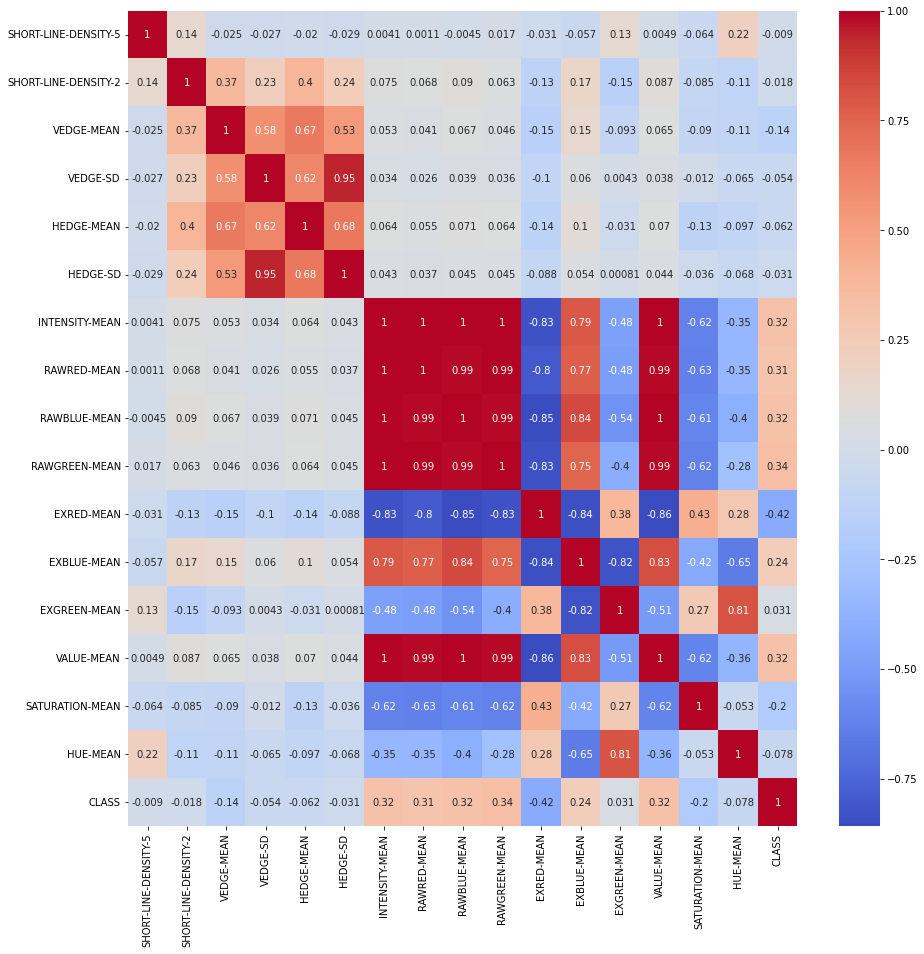

In [ ]:
df_v = df_raw_test.copy()
df_v['CLASS'] = LabelEncoder().fit_transform(df_v['CLASS'].tolist())
num_feat = df_v.select_dtypes(include=np.number).columns
plt.figure(figsize= (15, 15))
sns.heatmap(df_v.corr(), annot=True, cmap='coolwarm');

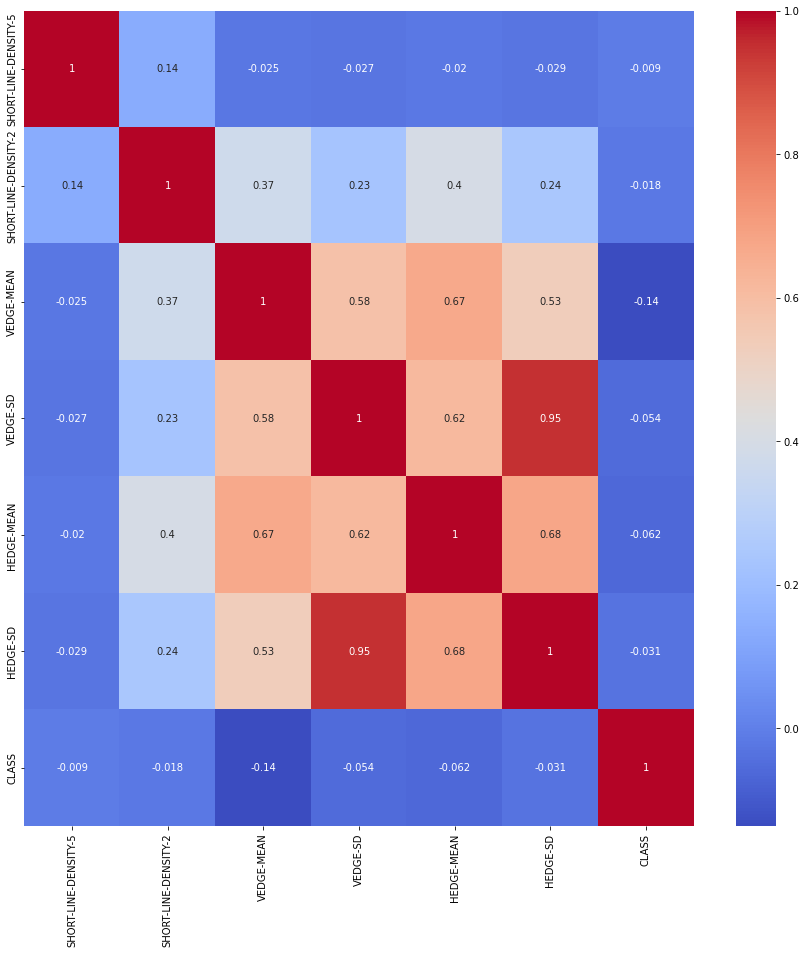

In [ ]:
df_v = df_raw_test1.copy()
df_v['CLASS'] = LabelEncoder().fit_transform(df_v['CLASS'].tolist())
num_feat = df_v.select_dtypes(include=np.number).columns
plt.figure(figsize= (15, 15))
sns.heatmap(df_v.corr(), annot=True, cmap='coolwarm');

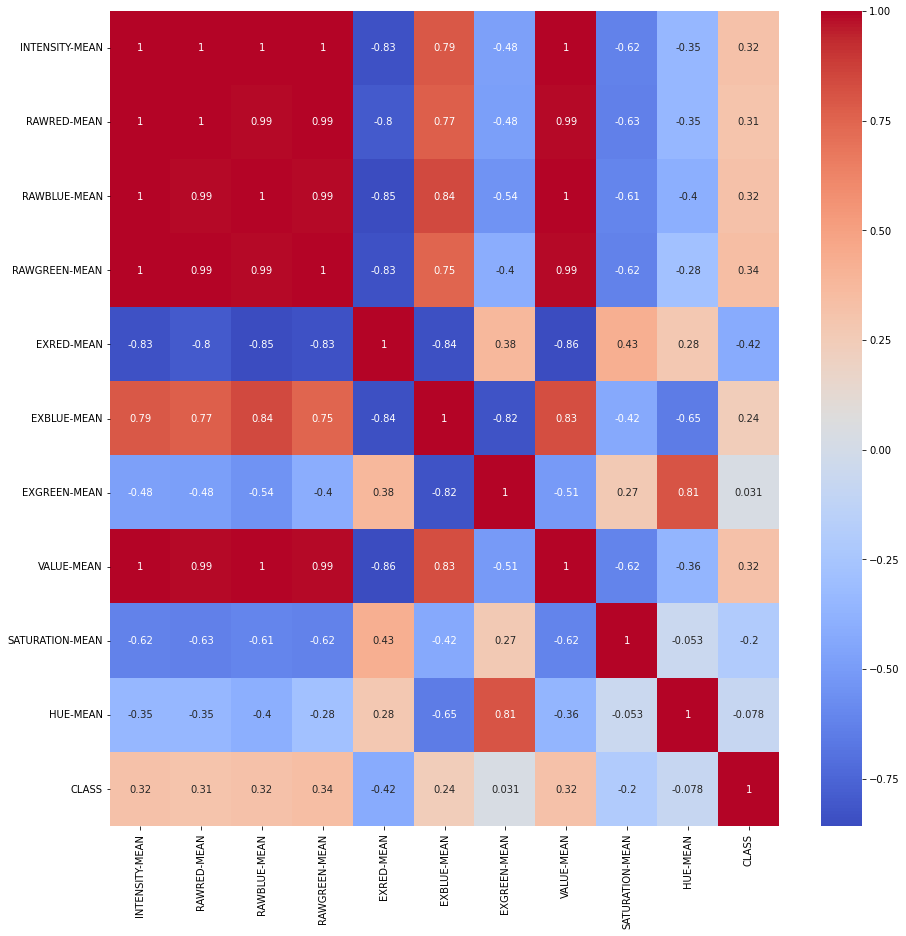

In [ ]:
df_v = df_raw_test2.copy()
df_v['CLASS'] = LabelEncoder().fit_transform(df_v['CLASS'].tolist())
num_feat = df_v.select_dtypes(include=np.number).columns
plt.figure(figsize= (15, 15))
sns.heatmap(df_v.corr(), annot=True, cmap='coolwarm');

### 3 PREPARAÇÃO DOS DADOS

___
Nesta fase será executada a manipulação dos dados para a modelagem. As atividades compreendidas são:


1.   Seleção dos dados: determinar quais dados serão usados;
2.   Limpeza dos dados;
3.   Construção de dados;
4.   Integração de dados;
5.   Adequação da formatação dos dados
___

#### 3.1 NORMALIZAÇÃO OS DADOS NÚMERICOS

In [ ]:
scaler = StandardScaler()

df_test_scaled = scaler.fit_transform(df_test)
df_test_scaled = pd.DataFrame(df_test_scaled, columns = ['SHORT-LINE-DENSITY-5','SHORT-LINE-DENSITY-2','VEDGE-MEAN','VEDGE-SD','HEDGE-MEAN','HEDGE-SD','INTENSITY-MEAN','RAWRED-MEAN','RAWBLUE-MEAN','RAWGREEN-MEAN','EXRED-MEAN','EXBLUE-MEAN','EXGREEN-MEAN','VALUE-MEAN','SATURATION-MEAN','HUE-MEAN'])

df_train_scaled = scaler.fit_transform(df_train)
df_train_scaled = pd.DataFrame(df_train_scaled, columns = ['SHORT-LINE-DENSITY-5','SHORT-LINE-DENSITY-2','VEDGE-MEAN','VEDGE-SD','HEDGE-MEAN','HEDGE-SD','INTENSITY-MEAN','RAWRED-MEAN','RAWBLUE-MEAN','RAWGREEN-MEAN','EXRED-MEAN','EXBLUE-MEAN','EXGREEN-MEAN','VALUE-MEAN','SATURATION-MEAN','HUE-MEAN'])

In [ ]:
# # Dataframe 1: apenas colunas de 4 a 9

# df_test_scaled1 = scaler.fit_transform(df_test1)
# df_test_scaled1 = pd.DataFrame(df_test_scaled1, columns = ['SHORT-LINE-DENSITY-5','SHORT-LINE-DENSITY-2','VEDGE-MEAN','VEDGE-SD','HEDGE-MEAN','HEDGE-SD'])

# df_train_scaled1 = scaler.fit_transform(df_train1)
# df_train_scaled1 = pd.DataFrame(df_train_scaled1, columns = ['SHORT-LINE-DENSITY-5','SHORT-LINE-DENSITY-2','VEDGE-MEAN','VEDGE-SD','HEDGE-MEAN','HEDGE-SD'])

# # Dataframe 2: apenas colunas de 10 a 16

# df_test_scaled2 = scaler.fit_transform(df_test2)
# df_test_scaled2 = pd.DataFrame(df_test_scaled2, columns = ['INTENSITY-MEAN','RAWRED-MEAN','RAWBLUE-MEAN','RAWGREEN-MEAN','EXRED-MEAN','EXBLUE-MEAN','EXGREEN-MEAN','VALUE-MEAN','SATURATION-MEAN','HUE-MEAN'])

# df_train_scaled2 = scaler.fit_transform(df_train2)
# df_train_scaled2 = pd.DataFrame(df_train_scaled2, columns = ['INTENSITY-MEAN','RAWRED-MEAN','RAWBLUE-MEAN','RAWGREEN-MEAN','EXRED-MEAN','EXBLUE-MEAN','EXGREEN-MEAN','VALUE-MEAN','SATURATION-MEAN','HUE-MEAN'])

In [ ]:
# Criado dataframes especificos

# Dataframe 1: apenas colunas de 4 a 9
df_test_scaled1 = df_test_scaled.drop(columns=['INTENSITY-MEAN','RAWRED-MEAN','RAWBLUE-MEAN','RAWGREEN-MEAN','EXRED-MEAN','EXBLUE-MEAN','EXGREEN-MEAN','VALUE-MEAN','SATURATION-MEAN','HUE-MEAN'], axis=1)
df_train_scaled1 = df_train_scaled.drop(columns=['INTENSITY-MEAN','RAWRED-MEAN','RAWBLUE-MEAN','RAWGREEN-MEAN','EXRED-MEAN','EXBLUE-MEAN','EXGREEN-MEAN','VALUE-MEAN','SATURATION-MEAN','HUE-MEAN'], axis=1)

# Dataframe 2: apenas colunas de 10 a 16
df_test_scaled2 = df_test_scaled.drop(columns=['SHORT-LINE-DENSITY-5','SHORT-LINE-DENSITY-2','VEDGE-MEAN','VEDGE-SD','HEDGE-MEAN','HEDGE-SD'], axis=1)
df_train_scaled2 = df_train_scaled.drop(columns=['SHORT-LINE-DENSITY-5','SHORT-LINE-DENSITY-2','VEDGE-MEAN','VEDGE-SD','HEDGE-MEAN','HEDGE-SD'], axis=1)

#### 3.2 TRATAMENTO DE ATRIBUTO CATEGORICO

---

Nessa etapa vamos transformar a variável categorica em variável númerica.

In [ ]:
label_e = LabelEncoder()
class_test = label_e.fit_transform(classes_test)
class_train = label_e.fit_transform(classes_train)

#### 3.3 DIVISÃO DE PREVISORES E CLASSE


A divisão será feita como:
*   X = Atritubos
*   Y = Classes

Será sepado 20% dos dados para teste e reservado 80% para treinamento e validação.

In [ ]:
y_test = np.array(class_test)
y_train = np.array(class_train)

# Dataframe completo
X_test = np.array(df_test_scaled)
X_train = np.array(df_train_scaled)

# Dataframe 1
X_test1 = np.array(df_test_scaled1)
X_train1 = np.array(df_train_scaled1)

# Dataframe 2
X_test2 = np.array(df_test_scaled2)
X_train2 = np.array(df_train_scaled2)

#### 3.4 VALIDAÇÃO CRUZADA

In [ ]:
seed=2

In [ ]:
# Validação cruzada estratificada (para busca de parametros)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [ ]:
# Validação cruzada estratificação com repetição (para treinamento de comite de voto marjoritário)

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=seed)

## 4 EFCM-LS1 (Fuzzy Clustering Algorithm)

### 4.1 Encontrando Matrizes G, V e U

#### 4.1.1 Dataframe Completo

____
Variaveis iniciais
____

In [ ]:
matriz_x = X_train
c = 7
E = 10 ** -10
T = 150

___
Algoritmo para encontrar as matrizes e calcular sua função objetivo
___

In [ ]:
temp = 10000 #Valor qualquer alto
i=0 #Interador da função objetivo -> 50

while(i < 50):
  matriz_u = random_matriz_u(matriz_x,c) # Aleatorizando a matriz U
  i += 1 #Interação de i

  for a in range(0, T):
    Tv = 10
    Tu = 0.1
    U_temp = matriz_u.copy() #copia para fazer o teste. Será o Ui-1

    matriz_g = calc_matriz_g(matriz_x, matriz_u) #Matriz G

    matriz_v = calc_matriz_v(matriz_x,matriz_u ,matriz_g,Tv = Tv) #Matriz V

    matriz_u = calc_matriz_u(matriz_x, matriz_g, matriz_v, Tu = Tu) #Matriz U

    matriz_test_U = np.abs(matriz_u - U_temp) #Matriz para teste do E (condição de parada)

    if matriz_test_U.max() < E:
      aux1 = JEFCMLS1(matriz_u, matriz_x, matriz_v, matriz_g, Tu = Tu, Tv = Tv)
      # Calculo da função objetivo
      if aux1 < temp: #Se a função objetivo for menor que a anterior, as matrizes são salvas

        matriz_g_final = matriz_g.copy()
        matriz_v_final = matriz_v.copy()
        matriz_u_final = matriz_u.copy()
        temp = aux1
        matriz_u = random_matriz_u(matriz_x,c)
        #Aleatoriza novamente a matriz U para uma proxima interação
      print('Interação do objetivo ',i, 'foram calculados em ',a, 'Interções')
      break

Interação de do objetivo  1 foram calculados em  31 Interções
Interação de do objetivo  2 foram calculados em  26 Interções
Interação de do objetivo  3 foram calculados em  25 Interções
Interação de do objetivo  4 foram calculados em  34 Interções
Interação de do objetivo  5 foram calculados em  36 Interções
Interação de do objetivo  6 foram calculados em  27 Interções
Interação de do objetivo  7 foram calculados em  37 Interções
Interação de do objetivo  8 foram calculados em  27 Interções
Interação de do objetivo  9 foram calculados em  40 Interções
Interação de do objetivo  10 foram calculados em  35 Interções
Interação de do objetivo  11 foram calculados em  31 Interções
Interação de do objetivo  12 foram calculados em  31 Interções
Interação de do objetivo  13 foram calculados em  27 Interções
Interação de do objetivo  14 foram calculados em  35 Interções
Interação de do objetivo  15 foram calculados em  25 Interções
Interação de do objetivo  16 foram calculados em  29 Interções
I

___
Visualização das matrizes final.
___

In [ ]:
df_matriz_g_final = pd.DataFrame(matriz_g_final)
df_matriz_g_final

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.363795,-0.193074,-0.273387,-0.109584,-0.309426,-0.131126,-0.417023,-0.391456,-0.408304,-0.392390,0.158308,-0.103273,-0.203406,-0.402736,-0.220694,-0.442753
1,-0.363795,-0.193074,-0.252413,-0.109372,-0.309426,-0.131243,-0.422852,-0.400983,-0.421075,-0.401574,0.158308,-0.108928,-0.184256,-0.410508,-0.198736,-0.445335
2,-0.363795,-0.193074,-0.273387,-0.109702,-0.309426,-0.131400,-0.417994,-0.391456,-0.410858,-0.395452,0.187080,-0.120237,-0.193831,-0.402736,-0.213595,-0.440956
3,-0.363795,-0.193074,-0.252413,-0.109125,-0.261383,-0.128371,-0.391766,-0.362873,-0.364881,-0.367900,0.148718,-0.075000,-0.184256,-0.379421,-0.255736,-0.445335
4,-0.363795,-0.193074,-0.189492,-0.105220,-0.229355,-0.126835,-0.378166,-0.356521,-0.349555,-0.343409,0.158308,-0.052381,-0.184256,-0.363877,-0.265665,-0.450139
5,-0.363795,-0.193074,-0.273387,-0.109584,-0.309426,-0.131126,-0.417023,-0.391456,-0.408304,-0.392390,0.158308,-0.103273,-0.203406,-0.402736,-0.220694,-0.442753
6,-0.363795,-0.193074,-0.189492,-0.105220,-0.229355,-0.126835,-0.378166,-0.356521,-0.349555,-0.343409,0.158308,-0.052381,-0.184256,-0.363877,-0.265665,-0.450139


In [ ]:
df_matriz_v_final = pd.DataFrame(matriz_v_final)
df_matriz_v_final

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000038,0.000231,5.436585e-05,0.493859,1.146819e-04,0.505702,1.436884e-09,1.531602e-09,6.385070e-10,2.230339e-09,5.909716e-10,6.993654e-11,4.361646e-10,8.328978e-10,1.416461e-09,2.239239e-07
1,0.000072,0.000098,2.567926e-05,0.323608,1.877964e-04,0.676008,2.419095e-09,2.530824e-09,1.084331e-09,3.734419e-09,9.850155e-10,1.185914e-10,6.903977e-10,1.396063e-09,1.572517e-09,4.112081e-07
2,0.000010,0.501974,2.187361e-05,0.262543,4.461154e-05,0.235406,3.654128e-10,3.961220e-10,1.545459e-10,5.692869e-10,1.197339e-10,1.350770e-11,8.508646e-11,2.072323e-10,3.086359e-10,3.503371e-08
3,0.000101,0.000037,4.689073e-05,0.985558,5.773903e-07,0.014256,2.193906e-09,2.351933e-09,9.786787e-10,3.589834e-09,9.790306e-10,1.297669e-10,7.617626e-10,1.303932e-09,1.618913e-09,4.285996e-07
4,0.000016,0.999702,1.377573e-09,0.000170,3.507951e-10,0.000113,7.688357e-11,8.847362e-11,2.866300e-11,1.455915e-10,2.069211e-11,1.949786e-12,1.354553e-11,4.066570e-11,1.768037e-11,1.997940e-08
5,0.000038,0.000231,5.436585e-05,0.493859,1.146819e-04,0.505702,1.436884e-09,1.531602e-09,6.385070e-10,2.230339e-09,5.909716e-10,6.993654e-11,4.361646e-10,8.328978e-10,1.416461e-09,2.239239e-07
6,0.000016,0.999702,1.377573e-09,0.000170,3.507951e-10,0.000113,7.688357e-11,8.847362e-11,2.866300e-11,1.455915e-10,2.069211e-11,1.949786e-12,1.354553e-11,4.066570e-11,1.768037e-11,1.997940e-08


In [ ]:
df_matriz_u_final = pd.DataFrame(matriz_u_final)
df_matriz_u_final

,0,1,2,3,4,5,6
0,0.140723,0.139808,0.143604,0.142196,0.146473,0.140723,0.146473
1,0.141809,0.141487,0.143423,0.142075,0.144699,0.141809,0.144699
2,0.132673,0.137184,0.147231,0.121047,0.164596,0.132673,0.164596
3,0.140793,0.143325,0.144151,0.134233,0.148353,0.140793,0.148353
4,0.141937,0.141693,0.143343,0.141412,0.144839,0.141937,0.144839
...,...,...,...,...,...,...,...
2095,0.140649,0.140021,0.143359,0.143662,0.145830,0.140649,0.145830
2096,0.132479,0.135797,0.147271,0.123822,0.164075,0.132479,0.164075
2097,0.136227,0.135779,0.145412,0.136889,0.154732,0.136227,0.154732
2098,0.136174,0.138750,0.145822,0.130128,0.156476,0.136174,0.156476


____
Calculo do Modified partition coefficient
___

In [ ]:
MPC(matriz_u_final)

0.5350485762987356

____
Calculo do Partition entropy
___

In [ ]:
VPE(matriz_u_final)

7.344767156516437

____
Calculo do crisp e calculo do índice de Rand corrigido e a F-measure (adaptada para agrupamento)
___

In [ ]:
crisp_completo= crisp_partition(matriz_u_final, c)
crisp_completo

array([4, 4, 4, ..., 4, 4, 4])

___
F-measure
___

In [ ]:
f1_score(y_train, crisp_completo,average='weighted')

0.03822895925123188

In [ ]:
adjusted_rand_score(y_train, crisp_completo)

0.0007496603658785016

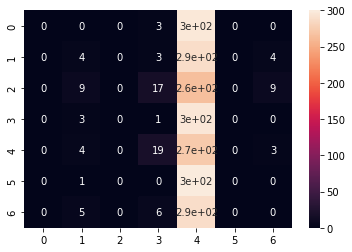

In [ ]:
sns.heatmap(confusion_matrix(y_train,crisp_completo),annot=True,vmax=300);

#### 4.1.2  Dataframe 1

____
Variaveis iniciais
____

In [ ]:
matriz_x = X_train1
c = 7
E = 10 ** -10
T = 150

___
Algoritmo para encontrar as matrizes e calcular sua função objetivo
___

In [ ]:
temp = 10000 #Valor qualquer alto
i=0 #Interador da função objetivo -> 50

while(i < 50):
  matriz_u = random_matriz_u(matriz_x,c) # Aleatorizando a matriz U
  i += 1 #Interação de i

  for a in range(0, T):
    Tv = 10
    Tu = 0.1
    U_temp = matriz_u.copy() #copia para fazer o teste. Será o Ui-1

    matriz_g = calc_matriz_g(matriz_x, matriz_u) #Matriz G

    matriz_v = calc_matriz_v(matriz_x,matriz_u ,matriz_g,Tv = Tv) #Matriz V

    matriz_u = calc_matriz_u(matriz_x, matriz_g, matriz_v, Tu = Tu) #Matriz U

    matriz_test_U = np.abs(matriz_u - U_temp) #Matriz para teste do E (condição de parada)

    if matriz_test_U.max() < E:
      aux1 = JEFCMLS1(matriz_u, matriz_x, matriz_v, matriz_g, Tu = Tu, Tv = Tv)
      # Calculo da função objetivo
      if aux1 < temp: #Se a função objetivo for menor que a anterior, as matrizes são salvas

        matriz_g_final1 = matriz_g.copy()
        matriz_v_final1 = matriz_v.copy()
        matriz_u_final1 = matriz_u.copy()
        temp = aux1
        matriz_u = random_matriz_u(matriz_x,c)
        #Aleatoriza novamente a matriz U para uma proxima interação
      print('Interação do objetivo ',i, 'foram calculados em ',a, 'Interções')
      break

___
Visualização das matrizes final.
___

In [ ]:
df_matriz_g_final1 = pd.DataFrame(matriz_g_final1)
df_matriz_g_final1

In [ ]:
df_matriz_v_final1 = pd.DataFrame(matriz_v_final1)
df_matriz_v_final1

In [ ]:
df_matriz_u_final1 = pd.DataFrame(matriz_u_final1)
df_matriz_u_final1

____
Calculo do Modified partition coefficient
___

In [ ]:
MPC(matriz_u_final1)

____
Calculo do Partition entropy
___

In [ ]:
VPE(matriz_u_final1)

____
Calculo do crisp e calculo do índice de Rand corrigido e a F-measure (adaptada para agrupamento)
___

In [ ]:
crisp_completo1= crisp_partition(matriz_u_final1, c)
crisp_completo1

In [ ]:
df_crisp_completo1 = pd.DataFrame(crisp_completo1)
df_crisp_completo1.value_counts(normalize = True, ascending=False)

___
F-measure
___

In [ ]:
f1_score(y_train, crisp_completo1,average='weighted')

___
Rand
___

In [ ]:
adjusted_rand_score(y_train, crisp_completo1)

___
Matriz de confusão
___

In [ ]:
sns.heatmap(confusion_matrix(y_train,crisp_completo1),annot=True,vmax=300);

#### 4.1.3  Dataframe 2

____
Variaveis iniciais
____

In [ ]:
matriz_x = X_train2
c = 7
E = 10 ** -10
T = 150

___
Algoritmo para encontrar as matrizes e calcular sua função objetivo
___

In [ ]:
temp = 10000 #Valor qualquer alto
i=0 #Interador da função objetivo -> 50

while(i < 50):
  matriz_u = random_matriz_u(matriz_x,c) # Aleatorizando a matriz U
  i += 1 #Interação de i

  for a in range(0, T):
    Tv = 10
    Tu = 0.1
    U_temp = matriz_u.copy() #copia para fazer o teste. Será o Ui-1

    matriz_g = calc_matriz_g(matriz_x, matriz_u) #Matriz G

    matriz_v = calc_matriz_v(matriz_x,matriz_u ,matriz_g,Tv = Tv) #Matriz V

    matriz_u = calc_matriz_u(matriz_x, matriz_g, matriz_v, Tu = Tu) #Matriz U

    matriz_test_U = np.abs(matriz_u - U_temp) #Matriz para teste do E (condição de parada)

    if matriz_test_U.max() < E:
      aux1 = JEFCMLS1(matriz_u, matriz_x, matriz_v, matriz_g, Tu = Tu, Tv = Tv)
      # Calculo da função objetivo
      if aux1 < temp: #Se a função objetivo for menor que a anterior, as matrizes são salvas

        matriz_g_final2 = matriz_g.copy()
        matriz_v_final2 = matriz_v.copy()
        matriz_u_final2 = matriz_u.copy()
        temp = aux1
        matriz_u = random_matriz_u(matriz_x,c)
        #Aleatoriza novamente a matriz U para uma proxima interação
      print('Interação em função objetivo ',i, 'foram calculados em ',a, 'Interções')
      break

Interação em função objetivo  1 foram calculados em  54 Interções
Interação em função objetivo  2 foram calculados em  49 Interções
Interação em função objetivo  3 foram calculados em  31 Interções
Interação em função objetivo  4 foram calculados em  53 Interções
Interação em função objetivo  5 foram calculados em  23 Interções
Interação em função objetivo  6 foram calculados em  21 Interções
Interação em função objetivo  7 foram calculados em  46 Interções
Interação em função objetivo  8 foram calculados em  27 Interções
Interação em função objetivo  9 foram calculados em  43 Interções
Interação em função objetivo  10 foram calculados em  28 Interções
Interação em função objetivo  11 foram calculados em  47 Interções
Interação em função objetivo  12 foram calculados em  44 Interções
Interação em função objetivo  13 foram calculados em  42 Interções
Interação em função objetivo  14 foram calculados em  53 Interções
Interação em função objetivo  15 foram calculados em  31 Interções
Inte

___
Visualização das matrizes final.
___

In [ ]:
df_matriz_g_final2 = pd.DataFrame(matriz_g_final2)
df_matriz_g_final2

,0,1,2,3,4,5,6,7,8,9
0,-0.450052,-0.410511,-0.487487,-0.450555,0.474797,-0.538683,0.026395,-0.457138,-0.086916,-0.014068
1,0.145436,0.148439,0.174075,0.100483,-0.129409,0.394338,-0.481082,0.154240,-0.520106,-0.472336
2,0.461152,0.440618,0.529122,0.372941,-0.608937,0.671417,-0.375757,0.514331,-0.579738,-0.589830
3,0.145436,0.148439,0.174075,0.100483,-0.129409,0.394338,-0.481082,0.154240,-0.520106,-0.472336
4,-0.586052,-0.604238,-0.699493,-0.459739,0.407663,-1.234208,1.749904,-0.604802,-0.022367,2.228176
5,-0.825996,-0.763031,-0.865522,-0.851589,1.098184,-0.951474,0.380672,-0.879403,0.577573,0.273713
6,0.145436,0.148439,0.174075,0.100483,-0.129409,0.394338,-0.481082,0.154240,-0.520106,-0.472336


In [ ]:
df_matriz_v_final2 = pd.DataFrame(matriz_v_final2)
df_matriz_v_final2

,0,1,2,3,4,5,6,7,8,9
0,3.125822e-01,2.003738e-01,1.132533e-01,1.034094e-01,5.616085e-05,4.881509e-06,1.345441e-12,2.480832e-01,2.223699e-02,3.238805e-12
1,5.663794e-11,5.492937e-11,4.852430e-11,8.431765e-11,3.828937e-10,7.122915e-10,1.242289e-07,3.351969e-11,3.564212e-10,9.999999e-01
2,4.373235e-16,3.303645e-16,1.402803e-15,2.088349e-16,7.152162e-13,1.363071e-10,2.908724e-06,8.384863e-16,8.345246e-11,9.999971e-01
3,5.663794e-11,5.492937e-11,4.852430e-11,8.431765e-11,3.828937e-10,7.122915e-10,1.242289e-07,3.351969e-11,3.564212e-10,9.999999e-01
4,2.485604e-01,2.319135e-01,1.849592e-01,1.206543e-01,8.740162e-04,3.503573e-04,2.242496e-08,2.119251e-01,7.631220e-04,1.271339e-09
5,2.429865e-01,1.557337e-01,2.834923e-01,1.454790e-01,3.100404e-05,3.599303e-03,3.956776e-06,1.686743e-01,2.849387e-10,3.589574e-09
6,5.663794e-11,5.492937e-11,4.852430e-11,8.431765e-11,3.828937e-10,7.122915e-10,1.242289e-07,3.351969e-11,3.564212e-10,9.999999e-01


In [ ]:
df_matriz_u_final2 = pd.DataFrame(matriz_u_final2)
df_matriz_u_final2

,0,1,2,3,4,5,6
0,0.161198,5.742389e-12,1.773477e-12,5.742389e-12,0.686686,0.152116,5.742389e-12
1,0.174389,4.170817e-12,1.288116e-12,4.170817e-12,0.715484,0.110127,4.170817e-12
2,0.150424,3.742332e-12,1.155789e-12,3.742332e-12,0.652566,0.197010,3.742332e-12
3,0.158693,7.309510e-12,2.257470e-12,7.309510e-12,0.676654,0.164653,7.309510e-12
4,0.289512,7.743071e-12,2.391369e-12,7.743071e-12,0.632773,0.077715,7.743071e-12
...,...,...,...,...,...,...,...
2095,0.017676,2.119159e-01,6.544720e-02,2.119159e-01,0.085060,0.196069,2.119159e-01
2096,0.014836,2.361639e-01,7.293560e-02,2.361639e-01,0.069105,0.134631,2.361639e-01
2097,0.012956,2.141764e-01,6.614525e-02,2.141764e-01,0.063261,0.215109,2.141764e-01
2098,0.024241,1.966858e-01,6.074367e-02,1.966858e-01,0.115021,0.209937,1.966858e-01


____
Calculo do Modified partition coefficient
___

In [ ]:
MPC(matriz_u_final2)

0.2505399470684999

____
Calculo do Partition entropy
___

In [ ]:
VPE(matriz_u_final2)

1.2455228328310222

____
Calculo do crisp e calculo do índice de Rand corrigido e a F-measure (adaptada para agrupamento)
___

In [ ]:
crisp_completo2= crisp_partition(matriz_u_final2, c)
crisp_completo2

array([4, 4, 4, ..., 5, 5, 1])

In [ ]:
df_crisp_completo2 = pd.DataFrame(crisp_completo2)
df_crisp_completo2.value_counts(normalize = False, ascending=False)

1    885
2    489
5    283
0    266
4    177
dtype: int64

In [ ]:
df_crisp_completo2.to_csv('df_crisp_completo2_train', index = False)

___
F-MEASURE
___

In [ ]:
f1_score(y_train, crisp_completo2,average='weighted')

0.20228730187588273

___
RAND
___

In [ ]:
adjusted_rand_score(y_train, crisp_completo2)

0.29016465034657485

___
MATRIZ CONFUSÃO
___

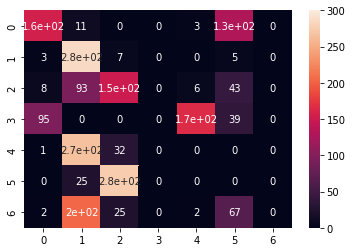

In [ ]:
sns.heatmap(confusion_matrix(y_train,crisp_completo2),annot=True,vmax=300);